In [1]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import json
import pickle
import librosa
import os
import soundfile as sf
from IPython.display import Audio, display
plt.style.use('default')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data_folder = r'/content/drive/MyDrive/'

# Speaker Verification - Siamese Network

In [3]:
#load trs and tes data
with open(data_folder+'trs.pkl','rb') as f:
  trs_data = pickle.load(f)

trs_spectogram = np.abs(np.array([librosa.stft(signal,n_fft=1024, hop_length=512) for signal in trs_data]))

with open(data_folder+'tes.pkl','rb') as f:
  tes_data = pickle.load(f)

tes_spectogram = np.abs(np.array([librosa.stft(signal,n_fft=1024, hop_length=512) for signal in tes_data]))

In [4]:
#check shape of spectograms
print(trs_spectogram.shape)
print(tes_spectogram.shape)

(500, 513, 32)
(200, 513, 45)


In [5]:
def create_pairs(spectogram_data):
  L = 45 #taking all possible pairs
  minibatch_pairs,minibatch_labels = [],[]
  for i in range(0,len(spectogram_data),10):
    positive_pairs,negative_pairs = [],[]
    speaker_data = spectogram_data[i:i+10]

    #generate all possible positive pairs(45 for each speaker)
    for j in range(len(speaker_data)):
      for k in range(j+1,len(speaker_data)):
        positive_pairs.append([speaker_data[j],speaker_data[k]])

    # Indices for the other 49 speakers
    other_speakers_indices = list(range(0, i)) + list(range(i + 10, len(spectogram_data)))

    #negative pairs
    for j in range(L):
      #choose random index for current speaker
      idx1 = np.random.choice(range(10))
      random_speaker_idx = np.random.choice(other_speakers_indices)
      #make sure that current speaker is not being chosen
      if i<=random_speaker_idx<i+10:
        print(random_speaker_idx)

      negative_pairs.append([speaker_data[idx1],spectogram_data[random_speaker_idx]])

    curr_pairs = positive_pairs+negative_pairs
    curr_labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

    indices = np.arange(len(curr_pairs))
    np.random.shuffle(indices)

    curr_pairs = np.array(curr_pairs)[indices].tolist()
    curr_labels = np.array(curr_labels)[indices].tolist()

    minibatch_pairs.extend(curr_pairs)
    minibatch_labels.extend(curr_labels)

  minibatch_pairs = np.array(minibatch_pairs)
  minibatch_labels = np.array(minibatch_labels)

  return minibatch_pairs,minibatch_labels

In [6]:
#traininig data mini batches
train_minibatch_pairs,train_minibatch_labels = create_pairs(trs_spectogram)

In [7]:
print(train_minibatch_pairs.shape)
print(train_minibatch_labels.shape)

(4500, 2, 513, 32)
(4500,)


In [8]:
#transpose to get T x 513
train_minibatch_pairs = train_minibatch_pairs.transpose(0,1,3,2)

In [9]:
print(train_minibatch_pairs.shape)

(4500, 2, 32, 513)


In [10]:
test_pairs,test_labels = create_pairs(tes_spectogram)
#transpose to get T x 513
test_pairs = test_pairs.transpose(0,1,3,2)
print(test_pairs.shape)
print(test_labels.shape)

(1800, 2, 45, 513)
(1800,)


In [63]:
#input shape
input_shape = (None,train_minibatch_pairs.shape[-1])

#define network so it can be used for both the inputs
def network(input_shape):
  sub_network = tf.keras.models.Sequential([
      tf.keras.layers.LSTM(64,return_sequences=True,input_shape = input_shape),
      tf.keras.layers.LSTM(64,return_sequences=False),
      tf.keras.layers.Dense(64,activation='relu') ])
  return sub_network


base_network = network(input_shape)

#two inputs
input_1 = tf.keras.layers.Input(shape=input_shape)
input_2 = tf.keras.layers.Input(shape=input_shape)

#latent encoded features
encoded1 = base_network(input_1)
encoded2 = base_network(input_2)

#inner product
inner_prod = tf.keras.layers.Dot(axes=1)([encoded1, encoded2])

#sigmoid
output = tf.keras.layers.Dense(1,activation='sigmoid')(inner_prod)

#siamese network
siamese_network = tf.keras.models.Model(inputs=[input_1, input_2], outputs=output)
siamese_network.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00003) ,loss='binary_crossentropy',metrics=['accuracy'])

In [64]:
base_network.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_16 (LSTM)              (None, None, 64)          147968    
                                                                 
 lstm_17 (LSTM)              (None, 64)                33024     
                                                                 
 dense_26 (Dense)            (None, 64)                4160      
                                                                 
Total params: 185152 (723.25 KB)
Trainable params: 185152 (723.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [65]:
siamese_network.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_27 (InputLayer)       [(None, None, 513)]          0         []                            
                                                                                                  
 input_28 (InputLayer)       [(None, None, 513)]          0         []                            
                                                                                                  
 sequential_13 (Sequential)  (None, 64)                   185152    ['input_27[0][0]',            
                                                                     'input_28[0][0]']            
                                                                                                  
 dot_13 (Dot)                (None, 1)                    0         ['sequential_13[0][0]',

In [66]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=35,restore_best_weights=True)

#fit the model
siamese_history = siamese_network.fit([train_minibatch_pairs[:,0], train_minibatch_pairs[:,1]], train_minibatch_labels,
                                      epochs=200, batch_size=90,validation_data=([test_pairs[:,0], test_pairs[:,1]], test_labels),callbacks=[early_stopping])

Epoch 1/200
50/50 [==============================] - 10s 73ms/step - loss: 0.7005 - accuracy: 0.5000 - val_loss: 0.6921 - val_accuracy: 0.5000
Epoch 2/200
50/50 [==============================] - 1s 23ms/step - loss: 0.6902 - accuracy: 0.5000 - val_loss: 0.6904 - val_accuracy: 0.4994
Epoch 3/200
50/50 [==============================] - 1s 25ms/step - loss: 0.6880 - accuracy: 0.5000 - val_loss: 0.6894 - val_accuracy: 0.4994
Epoch 4/200
50/50 [==============================] - 1s 30ms/step - loss: 0.6856 - accuracy: 0.4996 - val_loss: 0.6881 - val_accuracy: 0.4994
Epoch 5/200
50/50 [==============================] - 2s 38ms/step - loss: 0.6823 - accuracy: 0.4998 - val_loss: 0.6861 - val_accuracy: 0.4994
Epoch 6/200
50/50 [==============================] - 1s 26ms/step - loss: 0.6771 - accuracy: 0.4998 - val_loss: 0.6817 - val_accuracy: 0.4994
Epoch 7/200
50/50 [==============================] - 1s 24ms/step - loss: 0.6709 - accuracy: 0.5016 - val_loss: 0.6768 - val_accuracy: 0.5006
Epoch

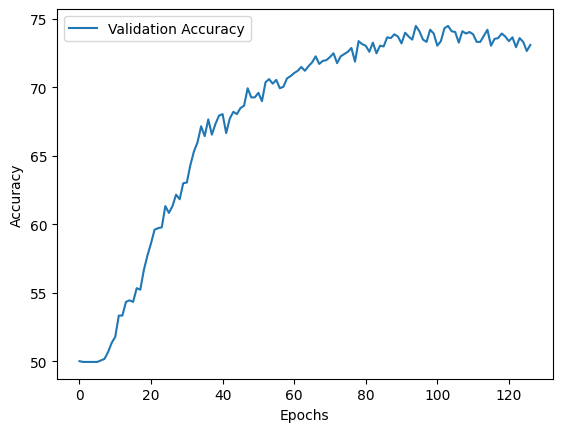

In [70]:
plt.plot([acc*100 for acc in siamese_history.history['val_accuracy']],label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [71]:
test_speaker_loss,test_speaker_acc = siamese_network.evaluate([test_pairs[:,0],test_pairs[:,1]],test_labels,verbose=0)
print(f'Speaker verification test data accuracy: {test_speaker_acc*100:.2f}%')

Speaker verification test data accuracy: 74.00%


- As expected, with just simple architecture(2 LSTM layers and 1 dense layer) 74% accuracy is achieved.